In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
from nets.cut import Cut
from pytorch_lightning import Trainer
# from data_loader_gaelle import ConcatDataset,ImageDataset,LotusDataModule, ConcatDataModule, LotusTrainTransforms2
import pandas as pd
import numpy as np 

from callbackss import logger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import NeptuneLogger
from pytorch_lightning.strategies.ddp import DDPStrategy

from monai.transforms import (  
    LoadImaged,
    Compose,
    Resize,
    RandZoomd,
    RandRotated,
    RandAffined,
    ToTensord
)   
import math

from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import SimpleITK as sitk
from PIL import Image
# import nrrd
import os
import sys
import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence
import monai
from monai.transforms import (  
    LoadImaged,
    Compose,
    Resize,
    RandZoomd,
    RandRotated,
    RandAffined,
    ToTensord,
    EnsureTyped,
    Spacingd,
    Resized,
    EnsureChannelFirstd
)   
import math

import pytorch_lightning as pl


<h1 style="font-size:24px; color:black; text-decoration:underline; font-weight:bold;">
  Reading CSV files for training
</h1>


In [2]:
df_train_cbct = pd.read_csv("/home/luciacev/Documents/Gaelle/Data/MultimodelReg/MRI_to_CBCT/training_CBCT/train.csv") 
df_val_cbct = pd.read_csv("/home/luciacev/Documents/Gaelle/Data/MultimodelReg/MRI_to_CBCT/training_CBCT/valid.csv")  
df_test_cbct = pd.read_csv("/home/luciacev/Documents/Gaelle/Data/MultimodelReg/MRI_to_CBCT/training_CBCT/test.csv")

df_train_mri = pd.read_csv("/home/luciacev/Documents/Gaelle/Data/MultimodelReg/MRI_to_CBCT/training_MRI/train.csv")
df_val_mri = pd.read_csv("/home/luciacev/Documents/Gaelle/Data/MultimodelReg/MRI_to_CBCT/training_MRI/valid.csv")   
df_test_mri = pd.read_csv("/home/luciacev/Documents/Gaelle/Data/MultimodelReg/MRI_to_CBCT/training_MRI/test.csv") 


print(df_train_mri.columns)  # Affiche les noms de colonnes du DataFrame
print(df_train_mri.head())   # Affiche les premières lignes pour vérifier les données


print("df_train_cbct : ",df_train_cbct)

Index(['index', 'img_fn', 'group', 'ignore_size_info', 'label'], dtype='object')
   index             img_fn group  ignore_size_info  label
0      0  train/M023_OR.nii     .                 0      1
1      1  train/M025_OR.nii     .                 0      2
2      2  train/M027_OR.nii     .                 0      3
3      3  train/M028_OR.nii     .                 0      4
4      4  train/M030_OR.nii     .                 0      5
df_train_cbct :      index                  img_fn group  ignore_size_info  label
0       0  train/B040_cropped.nii     .                 0      1
1       1  train/B041_cropped.nii     .                 0      2
2       2  train/M001_cropped.nii     .                 0      3
3       3  train/M002_cropped.nii     .                 0      4
4       4  train/M003_cropped.nii     .                 0      5
..    ...                     ...   ...               ...    ...
59     59  train/M061_cropped.nii     .                 0     60
60     60  train/M062_croppe

<h1 style="font-size:24px; color:black; text-decoration:underline; font-weight:bold;">
  Test transform on 1 file
</h1>

file :  train/B040_cropped.nii
file :  train/B041_cropped.nii
file :  train/M001_cropped.nii
file :  train/M002_cropped.nii
file :  train/M003_cropped.nii
file :  train/M004_cropped.nii
file :  train/M005_cropped.nii
file :  train/M006_cropped.nii
file :  train/M007_cropped.nii
file :  train/M008_cropped.nii
file :  train/M009_cropped.nii
file :  train/M010_cropped.nii
file :  train/M011_cropped.nii
file :  train/M012_cropped.nii
file :  train/M013_cropped.nii
file :  train/M014_cropped.nii
file :  train/M016_cropped.nii
file :  train/M017_cropped.nii
file :  train/M018_cropped.nii
file :  train/M019_cropped.nii
file :  train/M020_cropped.nii
file :  train/M022_cropped.nii
file :  train/M023_cropped.nii
file :  train/M024_cropped.nii
file :  train/M025_cropped.nii
file :  train/M027_cropped.nii
file :  train/M028_cropped.nii
file :  train/M029_cropped.nii
file :  train/M030_cropped.nii
file :  train/M031_cropped.nii
file :  train/M032_cropped.nii
file :  train/M033_cropped.nii
file :  

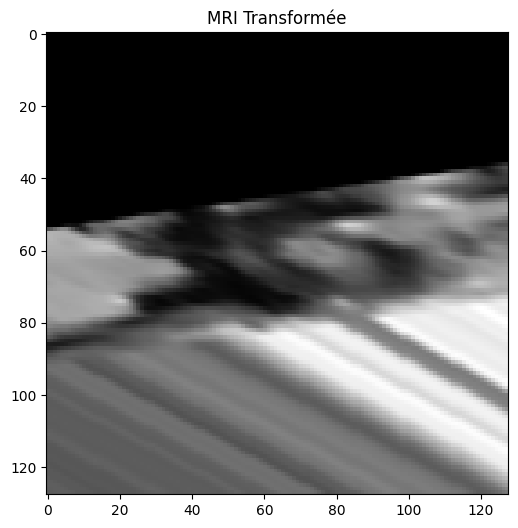

In [14]:
import matplotlib.pyplot as plt

img_path = "/home/luciacev/Documents/Gaelle/Data/MultimodelReg/MRI_to_CBCT/training_MRI/train/M023_OR.nii"
df = [{"img_mri": img_path, "img_cbct": img_path}]

transform_test = transforms.Compose(
    [   
        # EnsureChannelFirstd(keys=['img', 'seg'], channel_dim=-1),
        LoadImaged(keys=['img_mri', 'img_cbct']),
        RandZoomd(keys=['img_mri', 'img_cbct'], min_zoom=0.8, max_zoom=1.1, mode=['area', 'nearest'], prob=0.9, padding_mode='constant'),
        RandRotated(keys=['img_mri', 'img_cbct'], range_x=math.pi, mode=['bilinear', 'nearest'], prob=1.0),
        RandAffined(keys=['img_mri', 'img_cbct'], prob=0.8, shear_range=(0.1, 0.1), mode=['bilinear', 'nearest'], padding_mode='zeros'),
        ToTensord(keys=['img_mri', 'img_cbct'])
    ]

)

# Fonction pour imprimer et valider les données
def print_and_validate(data, message=""):
    print(message)
    if data is None:
        print("Error: Data is None")
        return data
    for key in data.keys():
        print(f"{key} - Size: {data[key].shape}")
    return data
# Fonction pour imprimer la taille et l'espacement
def print_info(data, message=""):
    print(message)
    for key in data.keys():
        if isinstance(data[key], np.ndarray):
            print(f"{key} - Size: {data[key].shape}, Spacing: Unknown without metadata")
        elif isinstance(data[key], monai.data.meta_tensor.MetaTensor):
            print(f"{key} - Size: {data[key].shape}, Spacing: {data[key].meta['spacing'] if 'spacing' in data[key].meta else 'Not available'}")

# Définition des transformations
transform_test = Compose(
    [
        LoadImaged(keys=['img_mri', 'img_cbct']),
        EnsureChannelFirstd(keys=['img_mri', 'img_cbct']),
        lambda x: print_info(x, "Before transformations:") or x,
        lambda x: print_and_validate(x, "After LoadImaged") or x,

        EnsureTyped(keys=['img_mri', 'img_cbct']),
        lambda x: print_and_validate(x, "After AddChanneld") or x,
        RandZoomd(keys=['img_mri', 'img_cbct'], min_zoom=0.8, max_zoom=1.1, mode=['area', 'nearest'], prob=0.9, padding_mode='constant'),
        lambda x: print_and_validate(x, "After RandZoomd") or x,

        RandRotated(keys=['img_mri', 'img_cbct'], range_x=np.pi, mode=['bilinear', 'nearest'], prob=1.0),
        lambda x: print_and_validate(x, "After RandRotated") or x,
        
        RandAffined(keys=['img_mri', 'img_cbct'], prob=0.8, shear_range=(0.1, 0.1), mode=['bilinear', 'nearest'], padding_mode='zeros'),
        lambda x: print_and_validate(x, "After RandAffined") or x,

        Resized(keys=['img_mri', 'img_cbct'], spatial_size=(128, 128, 128)),  # Redimensionne les images
        lambda x: print_and_validate(x, "After Resized") or x,

        ToTensord(keys=['img_mri', 'img_cbct']),
        lambda x: print_info(x, "After transformations:") or x
    ]
)
df = [{"img": img_path}]
transform_test = Compose(
        [
    LoadImaged(keys=['img']),
    EnsureChannelFirstd(keys=['img']),

    EnsureTyped(keys=['img']),
    RandZoomd(keys=['img'], min_zoom=0.8, max_zoom=1.1, mode=['area'], prob=0.9, padding_mode='constant'),

    RandRotated(keys=['img'], range_x=np.pi, mode=['bilinear'], prob=1.0),

    RandAffined(keys=['img'], prob=0.8, shear_range=(0.1, 0.1), mode=['bilinear'], padding_mode='zeros'),

    Resized(keys=['img'], spatial_size=(128, 128, 128)),  # Redimensionne les images

    ToTensord(keys=['img']),
    ]
)

# Création d'un dataset pour appliquer les transformations
# dataset = Dataset([df], transform=transform_test)
dataset = monai.data.Dataset(data=df, transform=transform_test)

################################################### Test on every file
for file in df_train_cbct["img_fn"]:
    print("file : ",file)
    try : 
        
        dataset = monai.data.Dataset(data=df, transform=transform_test)
        # print(dataset)
    except Exception as e:
        print("Error : ",e)
        # continue
#################################################### fonctionne au dessous pour afficher une image
print("type(dataset) : ",type(dataset))
# print("dataset : ",dataset)
# Exécutez les transformations et récupérez les images en tenseurs
img_after = [data["img"] for data in dataset]
print("type(img_after) : ",type(img_after))
print("len(img_after) : ",len(img_after))
print("img_after.shape : ",img_after[0].shape)

# Affichez chaque image après les transformations
for i in range(len(img_after)):
    plt.figure("image", (12, 6))
    plt.title("MRI Transformée")
    plt.imshow(img_after[i][0, 64, :, :], cmap="gray")
    plt.show()

# Exécution des transformations
# _ = [data for data in dataset]

<h1 style="font-size:24px; color:black; text-decoration:underline; font-weight:bold;">
  OLD DEFINITION CLASS TO LOAD DATA
</h1>

In [70]:
class LotusTrainTransforms2:
    def __init__(self, height: int = 256):

        # image augmentation functions
        # self.train_transform = Compose(
        #     [   
        #     LoadImaged(keys=['img_mri', 'img_cbct']),
        #     RandZoomd(keys=['img_mri', 'img_cbct'], min_zoom=0.8, max_zoom=1.1, mode=['area', 'nearest'], prob=0.9, padding_mode='constant'),
        #     RandRotated(keys=['img_mri', 'img_cbct'], range_x=math.pi, mode=['bilinear', 'nearest'], prob=1.0),
        #     RandAffined(keys=['img_mri', 'img_cbct'], prob=0.8, shear_range=(0.1, 0.1), mode=['bilinear', 'nearest'], padding_mode='zeros'),
        #     ToTensord(keys=['img_mri', 'img_cbct'])
        #     ]
        # )
        self.train_transform = Compose(
            [
        LoadImaged(keys=['img']),
        EnsureChannelFirstd(keys=['img']),

        EnsureTyped(keys=['img']),
        RandZoomd(keys=['img'], min_zoom=0.8, max_zoom=1.1, mode=['area'], prob=0.9, padding_mode='constant'),

        RandRotated(keys=['img'], range_x=np.pi, mode=['bilinear'], prob=1.0),
        
        RandAffined(keys=['img'], prob=0.8, shear_range=(0.1, 0.1), mode=['bilinear'], padding_mode='zeros'),

        Resized(keys=['img'], spatial_size=(128, 128, 128)),  # Redimensionne les images

        ToTensord(keys=['img']),
        ]
        )


    # def __call__(self, inp):
    #     return self.train_transform(inp) 
    def __call__(self, inp):
        try:
            # print("inp : ", inp)
            # print("key inp : ", inp.keys())
            # return self.train_transform(inp)
            print("key inp : ", inp.keys())
            img_after = [self.train_transform(inp)["img"]]
            return torch.stack([data for data in img_after])
        except Exception as e:
            print("Erreur lors de l'application de la transformation:", e)
            print("Dictionnaire d'entrée :", inp)
            raise e

   

class LotusDataset(Dataset):
    def __init__(self, df, mount_point = "./", img_column="img_path", seg_column=None):
        self.df = df
        self.mount_point = mount_point
        self.img_column = img_column
        self.seg_column = seg_column
        
        self.loader = LoadImaged(keys=["img"])

    def __len__(self):
        return len(self.df.index)

    def __getitem__(self, idx):
        
        img_path = os.path.join(self.mount_point, self.df.iloc[idx][self.img_column])
        

        d = {"img": img_path}
        
        
        # d = self.loader(d)
        
        return d
    
class LotusDataModule(pl.LightningDataModule):
    def __init__(self, df_train, df_val, df_test, mount_point="./", batch_size=256, num_workers=4, img_column="img_path", train_transform=None, valid_transform=None, test_transform=None, drop_last=False):
        super().__init__()

        self.df_train = df_train
        self.df_val = df_val
        self.df_test = df_test
        self.mount_point = mount_point
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.img_column = img_column        
        self.train_transform = train_transform
        self.valid_transform = valid_transform
        self.test_transform = test_transform
        self.drop_last=drop_last        

    def setup(self, stage=None):

        # Assign train/val datasets for use in dataloaders
        self.train_ds = monai.data.Dataset(data=LotusDataset(self.df_train, self.mount_point, img_column=self.img_column), transform=self.train_transform)
        self.val_ds = monai.data.Dataset(data=LotusDataset(self.df_val, self.mount_point, img_column=self.img_column), transform=self.valid_transform)
        self.test_ds = monai.data.Dataset(data=LotusDataset(self.df_test, self.mount_point, img_column=self.img_column), transform=self.test_transform)

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, num_workers=self.num_workers, persistent_workers=True, pin_memory=True, drop_last=self.drop_last, shuffle=True, prefetch_factor=2)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size, num_workers=self.num_workers, persistent_workers=False, pin_memory=True, drop_last=self.drop_last)

    def test_dataloader(self):
        return DataLoader(self.test_ds, batch_size=self.batch_size, num_workers=self.num_workers, persistent_workers=True, pin_memory=True, drop_last=self.drop_last)
    
class ConcatDataset(torch.utils.data.Dataset):
    def __init__(self, *datasets, use_max=True):
        self.datasets = datasets
        self.use_max = use_max

    def __getitem__(self, i):
        # print(f"Fetching index: {i}") #debug
        # for d in self.datasets:
            # print(f"Dataset length: {len(d)}") #debug
        return tuple(self.check_len(d, i) for d in self.datasets)

    def __len__(self):
        if self.use_max:
            return max(len(d) for d in self.datasets)
        return min(len(d) for d in self.datasets)

    def shuffle(self):
        for d in self.datasets:
            if isinstance(d, monai.data.Dataset):                
                d.data.df = d.data.df.sample(frac=1.0).reset_index(drop=True)                
            else:
                d.df = d.df.sample(frac=1.0).reset_index(drop=True)

    def check_len(self, d, i):
        if i < len(d):
            return d[i]
        else:
            j = i % len(d)
            return d[j]
    
class ConcatDataModule(pl.LightningDataModule):
    def __init__(self, datasetA_train, datasetA_val, datasetB_train, datasetB_val, batch_size=8, num_workers=4):
        super().__init__()

        self.datasetA_train = datasetA_train
        self.datasetB_train = datasetB_train

        self.datasetA_val = datasetA_val
        self.datasetB_val = datasetB_val
        
        self.batch_size = batch_size
        self.num_workers = num_workers

    def setup(self, stage=None):

        # Assign train/val datasets for use in dataloaders        
        self.train_ds =  ConcatDataset(self.datasetA_train, self.datasetB_train)
        self.val_ds = ConcatDataset(self.datasetA_val, self.datasetB_val)

    def train_dataloader(self):
        print("train_ds : ",self.train_ds)
        
        self.train_ds.shuffle()
        return DataLoader(self.train_ds, batch_size=self.batch_size, num_workers=self.num_workers, pin_memory=True, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size, num_workers=self.num_workers, pin_memory=True)   

<h1 style="font-size:24px; color:black; text-decoration:underline; font-weight:bold;">
  New defintion of class to load data + test size after loading them
</h1>

In [11]:
# TEST 2 DES CLASSES POUR LE DATASET

from pytorch_lightning.utilities.types import TRAIN_DATALOADERS


class LotusDataset(Dataset):
    def __init__(self, df, mount_point = "./", img_column="img_path", seg_column=None,transform=None):
        self.df = df
        self.mount_point = mount_point
        self.img_column = img_column
        self.seg_column = seg_column
        self.transform = transform
        
        self.loader = LoadImaged(keys=["img"])

    def __len__(self):
        return len(self.df.index)

    def __getitem__(self, idx):
        
        img_path = os.path.join(self.mount_point, self.df.iloc[idx][self.img_column])
        

        d = {"img": img_path}
        # print("type d : ", type(d))
        
        d = self.loader(d)

        if self.transform:
            # print("Dictionnaire apres load : ", d)
            d = self.transform(d)

        # print("type d : ", type(d))
        # print("size d[img] : ", d["img"].size())
        # print("number key : ", len(d.keys()))
        
        return d["img"]
    
class LotusDataModule(pl.LightningDataModule):
    def __init__(self, df_train, df_val, df_test, mount_point="./", batch_size=256, num_workers=4, img_column="img_path", train_transform=None, valid_transform=None, test_transform=None, drop_last=False):
        super().__init__()

        self.df_train = df_train
        self.df_val = df_val
        self.df_test = df_test
        self.mount_point = mount_point
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.img_column = img_column        
        self.train_transform = train_transform
        self.valid_transform = valid_transform
        self.test_transform = test_transform
        self.drop_last=drop_last        

    def setup(self, stage=None):

        # Assign train/val datasets for use in dataloaders
        # self.train_ds = monai.data.Dataset(data=LotusDataset(self.df_train, self.mount_point, img_column=self.img_column), transform=self.train_transform)
        # self.val_ds = monai.data.Dataset(data=LotusDataset(self.df_val, self.mount_point, img_column=self.img_column), transform=self.valid_transform)
        # self.test_ds = monai.data.Dataset(data=LotusDataset(self.df_test, self.mount_point, img_column=self.img_column), transform=self.test_transform)
        self.train_ds = LotusDataset(self.df_train, self.mount_point, img_column=self.img_column,transform=self.train_transform)
        self.val_ds = LotusDataset(self.df_val, self.mount_point, img_column=self.img_column,transform=self.valid_transform)
        self.test_ds = LotusDataset(self.df_test, self.mount_point, img_column=self.img_column,transform=self.test_transform)
        return DataLoader(self.train_ds, batch_size=self.batch_size, num_workers=self.num_workers, persistent_workers=True, pin_memory=True, drop_last=self.drop_last, shuffle=True, prefetch_factor=2)

    def train_dataloader(self) :
        return DataLoader(self.train_ds, batch_size=self.batch_size, num_workers=self.num_workers, persistent_workers=False, pin_memory=True, drop_last=self.drop_last)
    
    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size, num_workers=self.num_workers, persistent_workers=False, pin_memory=True, drop_last=self.drop_last)

    def test_dataloader(self):
        return DataLoader(self.test_ds, batch_size=self.batch_size, num_workers=self.num_workers, persistent_workers=True, pin_memory=True, drop_last=self.drop_last)
    
class LotusTrainTransforms2:
    def __init__(self, height: int = 256,size=128, pad=16):
        self.train_transform = Compose(
            [
        # LoadImaged(keys=['img']),
        EnsureChannelFirstd(keys=['img']),

        EnsureTyped(keys=['img']),
        RandZoomd(keys=['img'], min_zoom=0.8, max_zoom=1.1, mode=['area'], prob=0.9, padding_mode='constant'),

        RandRotated(keys=['img'], range_x=np.pi, mode=['bilinear'], prob=1.0),
        
        RandAffined(keys=['img'], prob=0.8, shear_range=(0.1, 0.1), mode=['bilinear'], padding_mode='zeros'),

        Resized(keys=['img'], spatial_size=(128, 128, 128)),  # Redimensionne les images

        ToTensord(keys=['img']),
        ]
        )

    def __call__(self, inp):
        try:
            y = self.train_transform(inp)
            return y
        
        except Exception as e:
            print("Erreur lors de l'application de la transformation:", e)
            print("Dictionnaire d'entrée :", inp)
            raise e
        
class ConcatDataset(torch.utils.data.Dataset):
    def __init__(self, *datasets, use_max=True):
        self.datasets = datasets
        self.use_max = use_max

    def __getitem__(self, i):
        # print(f"Fetching index: {i}") #debug
        # for d in self.datasets:
            # print(f"Dataset length: {len(d)}") #debug
        return tuple(self.check_len(d, i) for d in self.datasets)

    def __len__(self):
        if self.use_max:
            return max(len(d) for d in self.datasets)
        return min(len(d) for d in self.datasets)

    def shuffle(self):
        for d in self.datasets:
            if isinstance(d, monai.data.Dataset):                
                d.data.df = d.data.df.sample(frac=1.0).reset_index(drop=True)                
            else:
                d.df = d.df.sample(frac=1.0).reset_index(drop=True)

    def check_len(self, d, i):
        if i < len(d):
            return d[i]
        else:
            j = i % len(d)
            return d[j]
    
class ConcatDataModule(pl.LightningDataModule):
    def __init__(self, datasetA_train, datasetA_val, datasetB_train, datasetB_val, batch_size=8, num_workers=4):
        super().__init__()

        self.datasetA_train = datasetA_train
        self.datasetB_train = datasetB_train

        self.datasetA_val = datasetA_val
        self.datasetB_val = datasetB_val
        
        self.batch_size = batch_size
        self.num_workers = num_workers

    def setup(self, stage=None):

        # Assign train/val datasets for use in dataloaders        
        self.train_ds =  ConcatDataset(self.datasetA_train, self.datasetB_train)
        self.val_ds = ConcatDataset(self.datasetA_val, self.datasetB_val)

    def train_dataloader(self):
        # print("train_ds : ",self.train_ds)
        
        self.train_ds.shuffle()
        return DataLoader(self.train_ds, batch_size=self.batch_size, num_workers=self.num_workers, pin_memory=True, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size, num_workers=self.num_workers, pin_memory=True)  
        

def test_each_image(data_module):
    # Initialisation du DataModule
    data_module.setup()

    # Test toutes les images dans chaque DataLoader
    def test_loader(loader, loader_name):
        print(f"Testing {loader_name} data...")

        for i, batch in enumerate(loader):
            try:
                # Si le batch est chargé sans erreur, on peut vérifier la taille ou d'autres propriétés.
                print(f"{loader_name} - Batch {i + 1}: Chargement réussi, taille du batch : {batch.size()}")
            except Exception as e:
                print(f"Erreur lors du chargement de {loader_name} - Batch {i + 1}: {e}")

    # Création des DataLoaders à partir du DataModule
    train_loader = data_module.train_dataloader()
    val_loader = data_module.val_dataloader()
    test_loader2 = data_module.test_dataloader()

    # Test des loaders
    test_loader(train_loader, "Train")
    test_loader(val_loader, "Validation")
    test_loader(test_loader2, "Test")

def test_each_image_concat(data_module):
    # Initialisation du DataModule
    data_module.setup()

    # Fonction pour tester chaque DataLoader
    def test_loader_concat(loader, loader_name):
        print(f"Testing {loader_name} data...")

        for i, batch in enumerate(loader):
            try:
                # Si le lot est chargé sans erreur, on peut vérifier ses propriétés
                print(f"{loader_name} - Batch {i + 1}: Chargement réussi, taille du batch : {[b.shape for b in batch]}")
            except Exception as e:
                print(f"Erreur lors du chargement de {loader_name} - Batch {i + 1}: {e}")

    # Création des DataLoaders depuis le DataModule
    train_loader = data_module.train_dataloader()
    val_loader = data_module.val_dataloader()

    # Test des loaders
    test_loader_concat(train_loader, "Train")
    test_loader_concat(val_loader, "Validation")


train_transform_cbct = LotusTrainTransforms2()
valid_transform_cbct = LotusTrainTransforms2()
CBCT_data = LotusDataModule(df_train_cbct, df_val_cbct, df_test_cbct, mount_point="/home/luciacev/Documents/Gaelle/Data/MultimodelReg/MRI_to_CBCT/training_CBCT/", batch_size=2, num_workers=4, img_column="img_fn", train_transform=train_transform_cbct, valid_transform=valid_transform_cbct, test_transform=valid_transform_cbct, drop_last=False)
# CBCT_data.setup()

test_each_image(CBCT_data)

train_transform_cbct2 = LotusTrainTransforms2()
valid_transform_cbct2 = LotusTrainTransforms2()
CBCT_data2 = LotusDataModule(df_train_cbct, df_val_cbct, df_test_cbct, mount_point="/home/luciacev/Documents/Gaelle/Data/MultimodelReg/MRI_to_CBCT/training_CBCT/", batch_size=2, num_workers=4, img_column="img_fn", train_transform=train_transform_cbct2, valid_transform=valid_transform_cbct2, test_transform=valid_transform_cbct2, drop_last=False)
CBCT_data2.setup()

concat_data = ConcatDataModule(CBCT_data2.train_ds, CBCT_data2.val_ds, CBCT_data.train_ds, CBCT_data.val_ds, batch_size=2, num_workers=4)
concat_data.setup()

# test_each_image_concat(concat_data)

Testing Train data...


Train - Batch 1: Chargement réussi, taille du batch : torch.Size([2, 1, 128, 128, 128])
Train - Batch 2: Chargement réussi, taille du batch : torch.Size([2, 1, 128, 128, 128])
Train - Batch 3: Chargement réussi, taille du batch : torch.Size([2, 1, 128, 128, 128])
Train - Batch 4: Chargement réussi, taille du batch : torch.Size([2, 1, 128, 128, 128])
Train - Batch 5: Chargement réussi, taille du batch : torch.Size([2, 1, 128, 128, 128])
Train - Batch 6: Chargement réussi, taille du batch : torch.Size([2, 1, 128, 128, 128])
Train - Batch 7: Chargement réussi, taille du batch : torch.Size([2, 1, 128, 128, 128])
Train - Batch 8: Chargement réussi, taille du batch : torch.Size([2, 1, 128, 128, 128])


KeyboardInterrupt: 

Sortie de test_each_image_concat(concat_data) : 
Testing Train data...
Train - Batch 1: Chargement réussi, taille du batch : [torch.Size([2, 1, 128, 128, 128]), torch.Size([2, 1, 128, 128, 128])]
Train - Batch 2: Chargement réussi, taille du batch : [torch.Size([2, 1, 128, 128, 128]), torch.Size([2, 1, 128, 128, 128])]


Sortie de test_each_image(CBCT_data) : 
Testing Train data...
Train - Batch 1: Chargement réussi, taille du batch : torch.Size([2, 1, 128, 128, 128])
Train - Batch 2: Chargement réussi, taille du batch : torch.Size([2, 1, 128, 128, 128])
Train - Batch 3: Chargement réussi, taille du batch : torch.Size([2, 1, 128, 128, 128])

<h1 style="font-size:24px; color:black; text-decoration:underline; font-weight:bold;">
  Load data for training with the class
</h1>

In [71]:
train_transform_mri = LotusTrainTransforms2()
valid_transform_mri = LotusTrainTransforms2()
MRI_data = LotusDataModule(df_train_mri, df_val_mri, df_test_mri, mount_point="/home/luciacev/Documents/Gaelle/Data/MultimodelReg/MRI_to_CBCT/training_MRI/", batch_size=2, num_workers=4, img_column="img_fn", train_transform=train_transform_mri, valid_transform=valid_transform_mri, test_transform=valid_transform_mri, drop_last=False)

MRI_data.setup()

train_transform_cbct = LotusTrainTransforms2()
valid_transform_cbct = LotusTrainTransforms2()
CBCT_data = LotusDataModule(df_train_cbct, df_val_cbct, df_test_cbct, mount_point="/home/luciacev/Documents/Gaelle/Data/MultimodelReg/MRI_to_CBCT/training_CBCT/", batch_size=2, num_workers=4, img_column="img_fn", train_transform=train_transform_cbct, valid_transform=valid_transform_cbct, test_transform=valid_transform_cbct, drop_last=False)
CBCT_data.setup()

concat_data = ConcatDataModule(MRI_data.train_ds, MRI_data.val_ds, CBCT_data.train_ds, CBCT_data.val_ds, batch_size=2, num_workers=4)
concat_data.setup()
print("concat_data : ",concat_data)
print("oui")

concat_data :  <__main__.ConcatDataModule object at 0x76e822ecf520>
oui


<h1 style="font-size:24px; color:black; text-decoration:underline; font-weight:bold;">
  Test batch after loading with class
</h1>

In [ ]:
print(torch.version.cuda)
for batch in concat_data.train_dataloader():
    images_mri = batch[0] 
    print("batch : ",batch)
    # images_mri = batch['img']
    
    # Afficher les tailles des tensors
    print("9"*50)
    print("type(images_mri) : ",type(images_mri))
    print("len(imares_mri) : ",len(images_mri))
    # print("Images MRI:", images_mri.shape)
    # print("Images MRI:", images_mri["img"].shape)
    # print("Images CBCT:", images_cbct.shape)
    


12.1
train_ds :  <__main__.ConcatDataset object at 0x76e822e66070>
key inp : key inp : key inp :   dict_keys(['img']) dict_keys(['img'])dict_keys(['img'])


key inp :  dict_keys(['img'])
key inp :  dict_keys(['img'])
key inp :  dict_keys(['img'])
key inp :  dict_keys(['img'])
key inp :  dict_keys(['img'])
key inp :  dict_keys(['img'])
key inp :  dict_keys(['img'])
key inp :  dict_keys(['img'])
key inp :  dict_keys(['img'])
key inp :  dict_keys(['img'])
key inp :  dict_keys(['img'])
key inp :  dict_keys(['img'])
key inp :  dict_keys(['img'])
key inp :  dict_keys(['img'])
key inp :  dict_keys(['img'])
key inp :  dict_keys(['img'])
key inp :  dict_keys(['img'])
batch :  [metatensor([[[[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
             0.0000e+00, 0.0000e+00],
            [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
             0.0000e+00, 0.0000e+00],
            [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
             0.0000e+00, 0.0000e+00],
    

KeyboardInterrupt: 

key inp :  dict_keys(['img'])
key inp :  dict_keys(['img'])
key inp :  dict_keys(['img'])
key inp :  dict_keys(['img'])
key inp :  dict_keys(['img'])
key inp :  dict_keys(['img'])
key inp :  dict_keys(['img'])
key inp :  dict_keys(['img'])
key inp :  dict_keys(['img'])
key inp :  dict_keys(['img'])
key inp :  dict_keys(['img'])
key inp :  dict_keys(['img'])
key inp :  dict_keys(['img'])
key inp :  dict_keys(['img'])
key inp :  dict_keys(['img'])
key inp :  dict_keys(['img'])
key inp :  dict_keys(['img'])
key inp :  dict_keys(['img'])
key inp :  dict_keys(['img'])
key inp :  dict_keys(['img'])
key inp :  dict_keys(['img'])
key inp :  dict_keys(['img'])
key inp :  dict_keys(['img'])
key inp :  dict_keys(['img'])


<h1 style="font-size:24px; color:black; text-decoration:underline; font-weight:bold;">
  TEST CUDA
</h1>

In [ ]:
import os
import torch

# Remplacez l'index par celui de votre GPU si nécessaire
gpu_index = 0

# Définir la variable d'environnement CUDA_VISIBLE_DEVICES
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_index)
print(os.environ["CUDA_VISIBLE_DEVICES"])

# Vérifier si CUDA est disponible
cuda_available = torch.cuda.is_available()
print(torch.version.cuda)

if cuda_available:
    # Vérifier le nombre de GPU disponibles
    num_gpus = torch.cuda.device_count()
    print("num_gpus : ",num_gpus)

    # Afficher des informations sur chaque GPU disponible
    for i in range(num_gpus):
        gpu_name = torch.cuda.get_device_name(i)
        print(f"GPU {i}: {gpu_name}")

    # Afficher le GPU actuellement utilisé par PyTorch
    current_device = torch.cuda.current_device()
    print(f"GPU actuel: {torch.cuda.get_device_name(current_device)}")

    # Afficher la version de CUDA
    cuda_version = torch.version.cuda
    print(f"Version CUDA: {cuda_version}")
else:
    print("CUDA n'est pas disponible sur cet environnement.")

0
12.1
CUDA n'est pas disponible sur cet environnement.


/home/luciacev/APP/miniconda3/envs/pl/lib/python3.9/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


<h1 style="font-size:24px; color:black; text-decoration:underline; font-weight:bold;">
  Definition of everythings to train
</h1>

In [ ]:
checkpoint_callback = ModelCheckpoint(
            dirpath='/home/luciacev/Documents/Gaelle/Data/MultimodelReg_2/MRI_to_CBCT/output_train/',
            filename='{epoch}-{val_loss:.2f}',
            save_top_k=2,
            monitor='val_loss'
        )

early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=30, verbose=True, mode="min")

callbacks=[early_stop_callback, checkpoint_callback]
neptune_logger = None

os.environ['NEPTUNE_API_TOKEN'] = 'eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI4ZDQ0NTI4Yi03ZWI3LTRiN2UtODAwMi04MThhYzAwNWJhZDgifQ=='

neptune_logger = NeptuneLogger(
    project='gaellel/MRICBCT',
    tags=["v1"],
    api_key=os.environ['NEPTUNE_API_TOKEN']
)

LOGGER = getattr(logger, "CutLogger")    
image_logger = LOGGER(log_steps=100)
callbacks.append(image_logger)


<h1 style="font-size:24px; color:black; text-decoration:underline; font-weight:bold;">
  Train model
</h1>

In [ ]:
trainer = Trainer(
    logger=neptune_logger,
    log_every_n_steps=100,
    max_epochs=200,
    max_steps=-1,
    callbacks=callbacks,
    accelerator='gpu', 
    devices=torch.cuda.device_count(),
    strategy=DDPStrategy(find_unused_parameters=False),
    reload_dataloaders_every_n_epochs=1
    # detect_anomaly=True
)
    

MisconfigurationException: `Trainer(strategy=<pytorch_lightning.strategies.ddp.DDPStrategy object at 0x79ff635400a0>)` is not compatible with an interactive environment. Run your code as a script, or choose a notebook-compatible strategy: `Trainer(strategy='ddp_notebook')`. In case you are spawning processes yourself, make sure to include the Trainer creation inside the worker function.